# INITIAL IMPORTS

In [2]:
#Basics
import pandas as pd
import numpy as np
from pathlib import Path
import os
import seaborn as sns
import nltk
import re
import matplotlib.pyplot as plt

%matplotlib inline

#SKLearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score

#Metrics
import sklearn
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, accuracy_score, balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, multilabel_confusion_matrix, confusion_matrix
from sklearn.metrics import classification_report

#Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb

# performance check
import time
import warnings
warnings.filterwarnings("ignore")

# READ DATA

In [3]:
df_train = pd.read_csv(r"C:\Users\new_c\Desktop\NSIC Training\Project\Resources\df_train.csv")
df_train.head()

,type,posts,words_per_comment,variance_of_word_counts,http_per_comment,img_per_comment,qm_per_comment,excl_per_comment,ellipsis_per_comment,E,...,T,P,J,nouns_per_comment,adjs_per_comment,verbs_per_comment,prepositions_per_comment,interjections_per_comment,determiners_per_comment,sentiment
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,11.12,135.2900,0.48,0.12,0.36,0.06,0.30,0,...,0,0,1,5.18,1.62,1.72,0.54,0.00,1.06,0.166656
1,ENTP,'I'm finding the lack of me in these posts ver...,23.40,187.4756,0.20,0.02,0.10,0.00,0.38,1,...,1,1,0,3.98,2.12,4.68,2.72,0.04,1.84,0.104312
2,INTP,'Good one _____ https://www.youtube.com/wat...,16.72,180.6900,0.10,0.00,0.24,0.08,0.26,0,...,1,1,0,2.70,1.68,3.10,1.32,0.08,1.10,0.145745
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",21.28,181.8324,0.04,0.00,0.22,0.06,0.52,0,...,1,0,1,3.28,1.80,4.14,1.88,0.04,1.86,0.131263
4,ENTJ,'You're fired.|||That's another silly misconce...,19.34,196.4576,0.12,0.04,0.20,0.02,0.42,1,...,1,0,1,3.58,1.80,4.42,1.78,0.06,1.60,0.075231


# MODELS WITHOUT TEXT

In [4]:
# setting X to clean_posts, compound sentiment score, pos tags and various other counts
X = df_train[
    [
        "sentiment",
        "nouns_per_comment",
        "adjs_per_comment",
        "verbs_per_comment",
        "prepositions_per_comment",
        "interjections_per_comment",
        "determiners_per_comment",
        "words_per_comment",
        "variance_of_word_counts",
        "http_per_comment",
        "img_per_comment",
        "qm_per_comment",
        "excl_per_comment",
        "ellipsis_per_comment",
    ]
]

# setting y to four target classes -> is_Extrovert, is_Sensing, is_Thinking, is_Judging
y = df_train["type"]

# ensuring that X and y row count matches
print(X.shape)
print(y.shape)

(8675, 14)
(8675,)


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
print ((X_train.shape),(y_train.shape),(X_test.shape),(y_test.shape))

(6940, 14) (6940,) (1735, 14) (1735,)


In [6]:
def baseline_report(model, X_train, X_test, y_train, y_test, name):
    strat_k_fold = StratifiedKFold(n_splits=5, shuffle=True)
    model.fit(X_train, y_train)
    accuracy     = np.mean(cross_val_score(model, X_train, y_train, cv=strat_k_fold, scoring='accuracy', n_jobs=-1))
    precision    = np.mean(cross_val_score(model, X_train, y_train, cv=strat_k_fold, scoring='precision_weighted', n_jobs=-1))
    recall       = np.mean(cross_val_score(model, X_train, y_train, cv=strat_k_fold, scoring='recall_weighted', n_jobs=-1))
    f1score      = np.mean(cross_val_score(model, X_train, y_train, cv=strat_k_fold, scoring='f1_weighted', n_jobs=-1))
    y_pred = model.predict(X_test)
    mcm = multilabel_confusion_matrix(y_test, y_pred)
    tn = mcm[:, 0, 0]
    tp = mcm[:, 1, 1]
    fn = mcm[:, 1, 0]
    fp = mcm[:, 0, 1]
    specificities = tn / (tn+fp)
    specificity = (specificities.sum())/ 16

    df_model = pd.DataFrame({'model'        : [name],
                             'accuracy'     : [accuracy],
                             'precision'    : [precision],
                             'recall'       : [recall],
                             'f1score'      : [f1score],
                             'specificity'  : [specificity]
                            })   
    return df_model

In [7]:
models = {'GaussianNaiveBayes': GaussianNB(),
          'Logistic': LogisticRegression(),
          'kNN': KNeighborsClassifier(),
          'DecisionTree': DecisionTreeClassifier(),
          'RandomForest': RandomForestClassifier(),
          'XGBoost': GradientBoostingClassifier()
         }

In [8]:
# Evaluation of models
models_svd = pd.concat([baseline_report(model, X_train, X_test, y_train, y_test, name) for (name, model) in models.items()])
models_svd.sort_values(by='f1score', axis=0, ascending=False, inplace=True)
models_svd

,model,accuracy,precision,recall,f1score,specificity
0,XGBoost,0.212824,0.171605,0.214265,0.183929,0.941384
0,RandomForest,0.216427,0.168606,0.215994,0.180421,0.941069
0,GaussianNaiveBayes,0.175648,0.179975,0.181124,0.156833,0.941225
0,DecisionTree,0.145965,0.149991,0.145821,0.145110,0.937504
0,kNN,0.152594,0.143342,0.157205,0.144598,0.937493
0,Logistic,0.211383,0.081635,0.211960,0.107002,0.937408


# FEATURE IMPORTANCE

In [9]:
# Extrovert/Introvert set
X_e = df_train.drop(['posts', 'type','E','I','S','N','F','T','P','J'], 1)
y_e = df_train['E']
print(df_train.columns)

Index(['type', 'posts', 'words_per_comment', 'variance_of_word_counts',
       'http_per_comment', 'img_per_comment', 'qm_per_comment',
       'excl_per_comment', 'ellipsis_per_comment', 'E', 'I', 'S', 'N', 'F',
       'T', 'P', 'J', 'nouns_per_comment', 'adjs_per_comment',
       'verbs_per_comment', 'prepositions_per_comment',
       'interjections_per_comment', 'determiners_per_comment', 'sentiment'],
      dtype='object')


In [10]:
# Sensing/Intuition set
X_s = df_train.drop(['posts', 'type','E','I','S','N','F','T','P','J'], 1)
y_s = df_train['S']

In [11]:
# Feeling/Thinking set
X_f = df_train.drop(['posts', 'type','E','I','S','N','F','T','P','J'], 1)
y_f = df_train['F']

In [12]:
# Judging/Perceiving set
X_j = df_train.drop(['posts', 'type','E','I','S','N','F','T','P','J'], 1)
y_j = df_train['J']

In [13]:
# Split the data set into a training set and a test set.
X_train_e, X_test_e, y_train_e, y_test_e = train_test_split(X_e, y_e, test_size = 0.3, random_state = 0)

X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_s, y_s, test_size = 0.3, random_state = 0)

X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(X_f, y_f, test_size = 0.3, random_state = 0)

X_train_j, X_test_j, y_train_j, y_test_j = train_test_split(X_j, y_j, test_size = 0.3, random_state = 0)

In [14]:
model_xgb_e = xgb.XGBClassifier(learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=250)
model_xgb_e.fit(X_train_e, y_train_e)

model_xgb_s = xgb.XGBClassifier(learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=250)
model_xgb_s.fit(X_train_s, y_train_s)

model_xgb_f = xgb.XGBClassifier(learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=250)
model_xgb_f.fit(X_train_f, y_train_f)

model_xgb_j = xgb.XGBClassifier(learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=250)
model_xgb_j.fit(X_train_j, y_train_j)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              n_estimators=250, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

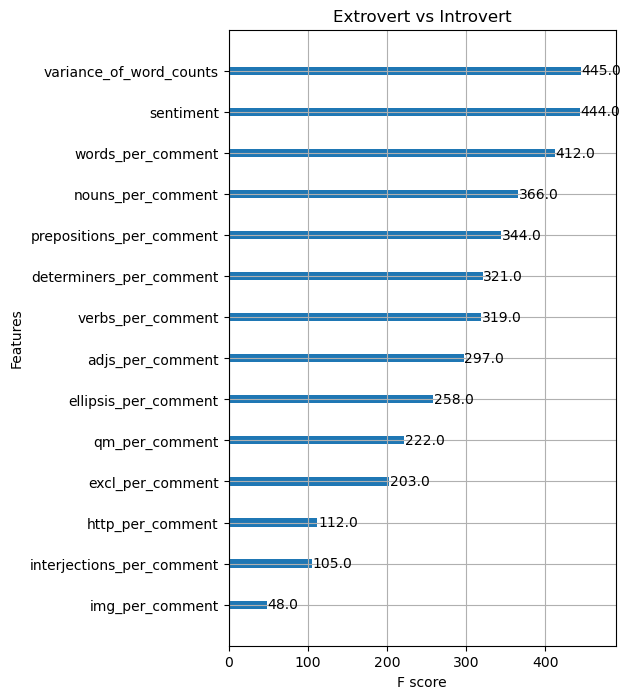

In [15]:
# Extrovert/Introvert
fig, ax = plt.subplots(figsize=(5,8))
xgb.plot_importance(model_xgb_e, ax=ax, title='Extrovert vs Introvert')
plt.show()

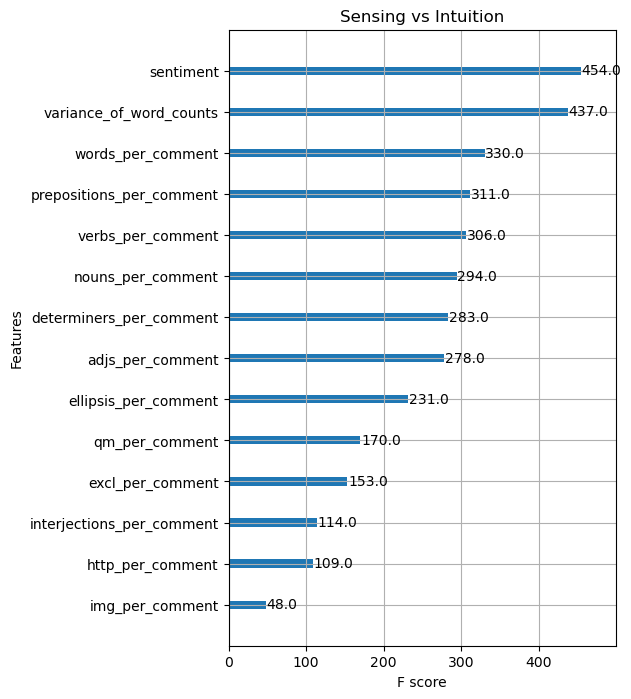

In [16]:
# For Sensing/Intuition
fig, ax = plt.subplots(figsize=(5,8))
xgb.plot_importance(model_xgb_s, ax=ax, title='Sensing vs Intuition')
plt.show()

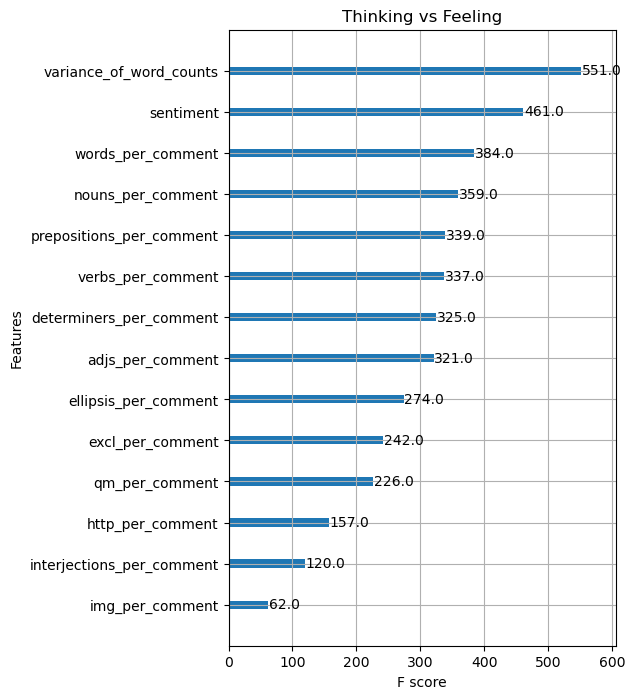

In [21]:
# Thinking/Feeling
fig, ax = plt.subplots(figsize=(5,8))
xgb.plot_importance(model_xgb_f, ax=ax, title='Thinking vs Feeling')
plt.show()

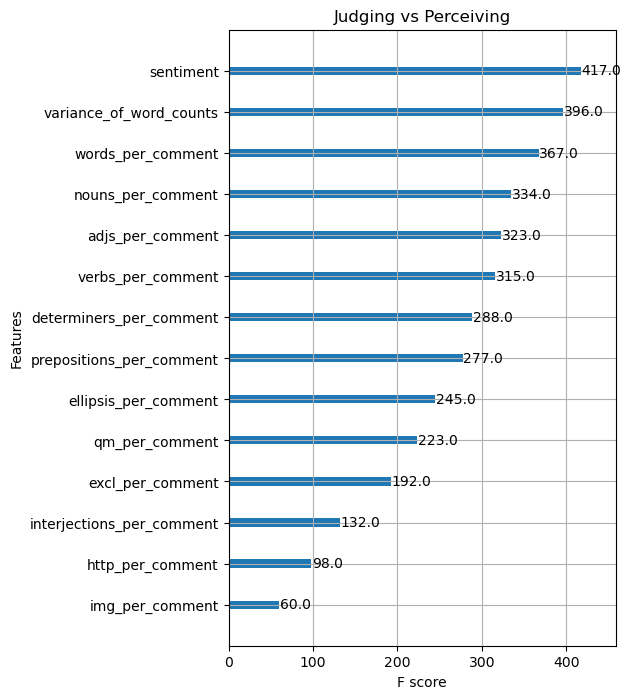

In [22]:
# Judging/Perceiving
fig, ax = plt.subplots(figsize=(5,8))
xgb.plot_importance(model_xgb_j, ax=ax, title='Judging vs Perceiving')
plt.show()